In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from qubic.lib.Qdictionary import qubicDict
from qubic.lib.Instrument.Qacquisition import QubicMultiAcquisitions
from qubic.lib.Qsamplings import get_pointing, equ2gal
from qubic.lib.Qscene import QubicScene
from qubic.lib.MapMaking.FrequencyMapMaking.Qspectra_component import CMBModel

from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator

%matplotlib inline

In [2]:
nside = 128
np.random.seed(6)

# Initialize QUBIC instance

Build the QUBIC dictionary, mandatory to use the QUBIC functions

In [3]:
# Build MPI communicator and qubic dict
dictfilename = 'qubic/qubic/dicts/pipeline_demo.dict'
d = qubicDict()
d.read_from_file(dictfilename)

center = equ2gal(d['RA_center'], d['DEC_center'])

d['nf_recon'] = 2
d['MultiBand'] = True
d['nside'] = nside

d['npointings'] = 10
d['synthbeam_kmax'] = 1
nf_sub = d['nf_sub']
d['synthbeam_fraction'] = 1

d['noiseless'] = True
d['photon_noise'] = False
d['use_synthbeam_fits_file'] = False

#d['nprocs_instrument'] = 1

In [4]:
d

{'debug': False,
 'config': 'FI',
 'filter_nu': 150000000000.0,
 'filter_relative_bandwidth': 0.25,
 'beam_shape': 'gaussian',
 'MultiBand': True,
 'nf_sub': 1,
 'center_detector': False,
 'psd': None,
 'bandwidth': None,
 'twosided': None,
 'sigma': None,
 'detector_nep': 4.7e-17,
 'detector_fknee': 0,
 'detector_fslope': 1,
 'detector_ncorr': 10,
 'detector_ngrids': 1,
 'detector_tau': 0.01,
 'polarizer': True,
 'synthbeam_fraction': 1,
 'synthbeam_kmax': 1,
 'synthbeam_peak150_fwhm': 0.39268176,
 'ripples': False,
 'nripples': 0,
 'focal_length': 0.3,
 'optics': 'CalQubic_Optics_v3_CC_FFF.txt',
 'primbeam': 'CalQubic_PrimBeam_v2.fits',
 'detarray': 'CalQubic_DetArray_v4_CC.fits',
 'hornarray': 'CalQubic_HornArray_CC.fits',
 'synthbeam': 'CalQubic_Synthbeam_Analytical_220_FI.fits',
 'nside': 128,
 'kind': 'IQU',
 'absolute': False,
 'temperature': 2.7255,
 'summer': False,
 'RA_center': 0.0,
 'DEC_center': -57.0,
 'period': 1.0,
 'date_obs': '2016-01-01 00:00:00',
 'latitude': -24.18

In [5]:
# Build scanning strategy
sampling = get_pointing(d)

# Build scene
scene = QubicScene(d)

In [6]:
# Number of sub-acquisitions
nsub_max = 14
nsub_list = np.arange(4, nsub_max + 1, 6)

In [7]:
# Build CMB map
cl_cmb = CMBModel(None).give_cl_cmb(r=0, Alens=1)
cmb_map = hp.synfast(cl_cmb, nside, new=True, verbose=False).T

map_title = "I, Q, U = 1"

In [8]:
TOD_list = []
tod_list = []
freq_list = []

for insub in nsub_list:
    print(f"Nsub = {insub}")
    input_maps = np.ones((insub, hp.nside2npix(nside), 3)) * cmb_map
    
    # Build acquisition operator
    Qacq = QubicMultiAcquisitions(d, insub, 2, sampling=sampling)
    
    # Build TOD
    tod = []
    _tod = []
    map_list = []
    for i in range(insub):
        P = Qacq.multiinstrument[i].get_projection_operator(sampling, scene)
        F = Qacq.multiinstrument[i].get_filter_operator()
        C = HealpixConvolutionGaussianOperator(fwhm=Qacq.allfwhm[i])
   
        tod.append(P(F(C(input_maps[i]))))
        _tod.append(P(C(input_maps[i])))
        
        del P, F, C

    TOD_list.append(np.sum(tod, axis=0))
    tod_list.append(_tod)
    freq_list.append(np.array(Qacq.allnus))
    
    del Qacq, tod, input_maps

Nsub = 4
Info DESKTOP-5T6UOML: Allocating (9920,9) elements = 1.3623046875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (9920,9) elements = 1.3623046875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (9920,9) elements = 1.3623046875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (9920,9) elements = 1.3623046875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (9920,9) elements = 1.3623046875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (9920,9) elements = 1.3623046875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (9920,9) elements = 1.3623046875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (9920,9) elements = 1.3623046875 MiB in FSRRotation3dMatrix.__init__.
Nsub = 10
Info DESKTOP-5T6UOML: Allocating (9920,9) elements = 1.3623046875 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (9920,9) elements = 1

In [9]:
# # Define a list of colors to use (you can choose your own)
# colors = px.colors.qualitative.Plotly

# fig = make_subplots(rows=1, cols=3, subplot_titles=("I", "Q", "U"))

# for i in range(nsub_list.size):
#     # Use the same legend group and color for all three traces of the same i.
#     group_name = f"group{i}"
#     color = colors[i % len(colors)]
    
#     # First subplot: show legend
#     fig.add_trace(go.Scatter(
#         y=np.mean(TOD_list[i], axis=0)[:, 0],
#         name=f"Nsub = {nsub_list[i]}",
#         legendgroup=group_name,
#         line=dict(color=color, width=1),
#         showlegend=True
#     ), row=1, col=1)
    
#     # Second subplot: hide legend
#     fig.add_trace(go.Scatter(
#         y=np.mean(TOD_list[i], axis=0)[:, 1],
#         legendgroup=group_name,
#         line=dict(color=color, width=1),
#         showlegend=False
#     ), row=1, col=2)
    
#     # Third subplot: hide legend
#     fig.add_trace(go.Scatter(
#         y=np.mean(TOD_list[i], axis=0)[:, 2],
#         legendgroup=group_name,
#         line=dict(color=color, width=1),
#         showlegend=False
#     ), row=1, col=3)

# fig.update_layout(
#     title=f"TOD - Mean over detector - Nside = {nside}",
#     xaxis_title="Pointing",
#     yaxis_title="TOD",
#     width=2500,  # Width in pixels
#     height=600   # Height in pixels
# )
# fig.update_yaxes(tickformat=".1e")  # Example: show scientific notation with 2 decimals

# fig.show()

In [10]:
# # Define a list of colors to use (you can choose your own)
# colors = px.colors.qualitative.Plotly

# fig = make_subplots(rows=1, cols=3, subplot_titles=("I", "Q", "U"))

# idet = 200

# for i in range(nsub_list.size):
#     # Use the same legend group and color for all three traces of the same i.
#     group_name = f"group{i}"
#     color = colors[i % len(colors)]
    
#     # First subplot: show legend
#     fig.add_trace(go.Scatter(
#         y=TOD_list[i][idet, :, 0],
#         name=f"Nsub = {nsub_list[i]}",
#         legendgroup=group_name,
#         line=dict(color=color, width=1),
#         showlegend=True
#     ), row=1, col=1)
    
#     # Second subplot: hide legend
#     fig.add_trace(go.Scatter(
#         y=TOD_list[i][idet, :, 1],
#         legendgroup=group_name,
#         line=dict(color=color, width=1),
#         showlegend=False
#     ), row=1, col=2)
    
#     # Third subplot: hide legend
#     fig.add_trace(go.Scatter(
#         y=TOD_list[i][idet, :, 2],
#         legendgroup=group_name,
#         line=dict(color=color, width=1),
#         showlegend=False
#     ), row=1, col=3)

# fig.update_layout(
#     title=f"TOD - Detector {idet}",
#     xaxis_title="Pointing",
#     yaxis_title="TOD",
# )
# fig.update_yaxes(tickformat=".1e")  # Example: show scientific notation with 2 decimals

# fig.show()

Text(0.5, 0.98, 'TOD - $H = P_{roj}C_{onv}$ - One Time Sample - Mean Over Detectors - Nside = 128')

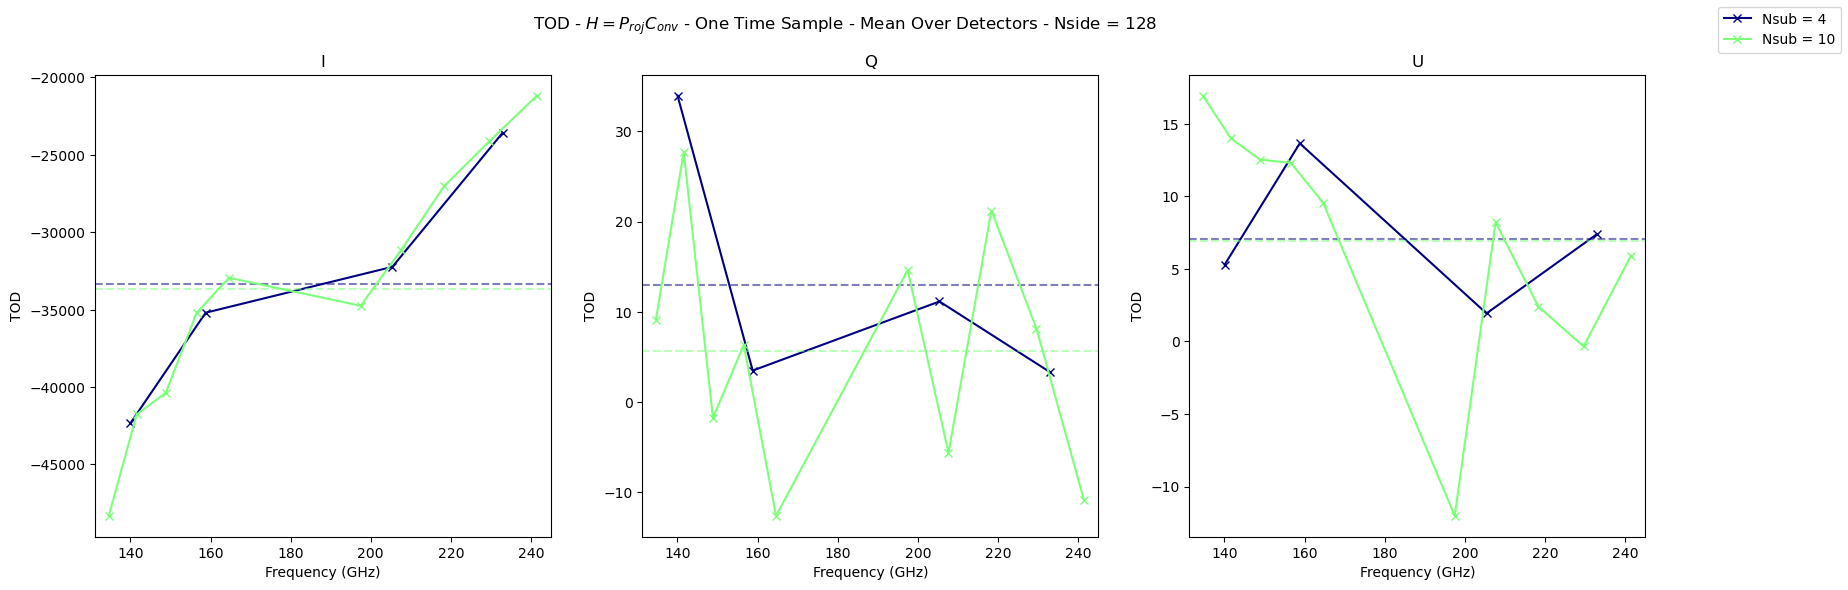

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

isample = 0

for i in range(len(tod_list)):  
    color = plt.cm.jet(i/len(tod_list))
    ax1.plot(freq_list[i], np.mean(np.array(tod_list[i])[..., isample, 0], axis=1), '-x', label = f"Nsub = {nsub_list[i]}", color=color)
    ax2.plot(freq_list[i], np.mean(np.array(tod_list[i])[..., isample, 1], axis=1), '-x', color=color)
    ax3.plot(freq_list[i], np.mean(np.array(tod_list[i])[..., isample, 2], axis=1), '-x', color=color)
    
    ax1.hlines(np.mean(np.mean(np.array(tod_list[i])[..., isample, 0], axis=1)), 131.25, 245, color=color, linestyle='--', alpha=0.5)
    ax2.hlines(np.mean(np.mean(np.array(tod_list[i])[..., isample, 1], axis=1)), 131.25, 245, color=color, linestyle='--', alpha=0.5)
    ax3.hlines(np.mean(np.mean(np.array(tod_list[i])[..., isample, 2], axis=1)), 131.25, 245, color=color, linestyle='--', alpha=0.5)
ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylabel("TOD")
ax1.set_title('I')
ax1.set_xlim(131.25, 245)

ax2.set_xlabel('Frequency (GHz)')
ax2.set_ylabel("TOD")
ax2.set_title('Q')
ax2.set_xlim(131.25, 245)

ax3.set_xlabel('Frequency (GHz)')
ax3.set_ylabel("TOD")
ax3.set_title('U')
ax3.set_xlim(131.25, 245)

fig.legend()
fig.suptitle(r'TOD - $H = P_{roj}C_{onv}$ - One Time Sample - Mean Over Detectors' + f' - Nside = {nside}')

In [12]:
np.shape(tod_list[0][0])

(992, 10, 3)

Text(0.5, 0.98, 'TOD - $H = P_{roj}C_{onv}$ - One Time Sample - Detector 0 - Nside = 128 - Map : I, Q, U = 1')

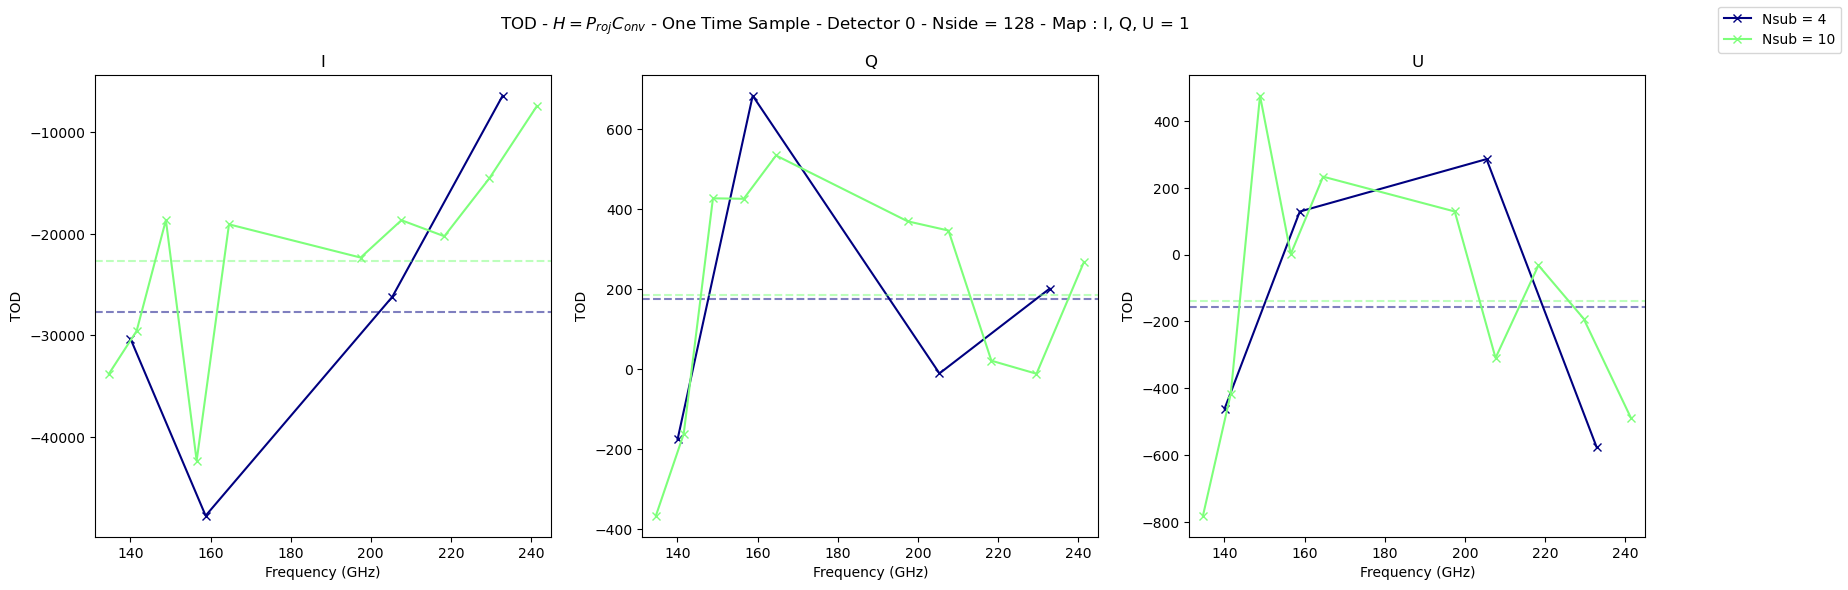

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

idet = 0

for i in range(len(tod_list)):  
    color = plt.cm.jet(i/len(tod_list))
    ax1.plot(freq_list[i], np.array(tod_list[i])[:, idet, isample, 0], '-x', label = f"Nsub = {nsub_list[i]}", color=color)
    ax2.plot(freq_list[i], np.array(tod_list[i])[:, idet, isample, 1], '-x', color=color)
    ax3.plot(freq_list[i], np.array(tod_list[i])[:, idet, isample, 2], '-x', color=color)
    
    ax1.hlines(np.mean(np.array(tod_list[i]), axis=0)[idet, isample, 0], 131.25, 245, color=color, linestyle='--', alpha=0.5)
    ax2.hlines(np.mean(np.array(tod_list[i]), axis=0)[idet, isample, 1], 131.25, 245, color=color, linestyle='--', alpha=0.5)
    ax3.hlines(np.mean(np.array(tod_list[i]), axis=0)[idet, isample, 2], 131.25, 245, color=color, linestyle='--', alpha=0.5)
ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylabel("TOD")
ax1.set_title('I')
ax1.set_xlim(131.25, 245)

ax2.set_xlabel('Frequency (GHz)')
ax2.set_ylabel("TOD")
ax2.set_title('Q')
ax2.set_xlim(131.25, 245)

ax3.set_xlabel('Frequency (GHz)')
ax3.set_ylabel("TOD")
ax3.set_title('U')
ax3.set_xlim(131.25, 245)

fig.legend()
fig.suptitle(r'TOD - $H = P_{roj}C_{onv}$ - One Time Sample' + f' - Detector {idet} - Nside = {nside} - Map : {map_title}')

Text(0.5, 0.98, 'TOD - $H = P_{roj}F_{ilter}C_{onv}$ - Mean Over Detectors -  - Nside = 128 - Map : I, Q, U = 1')

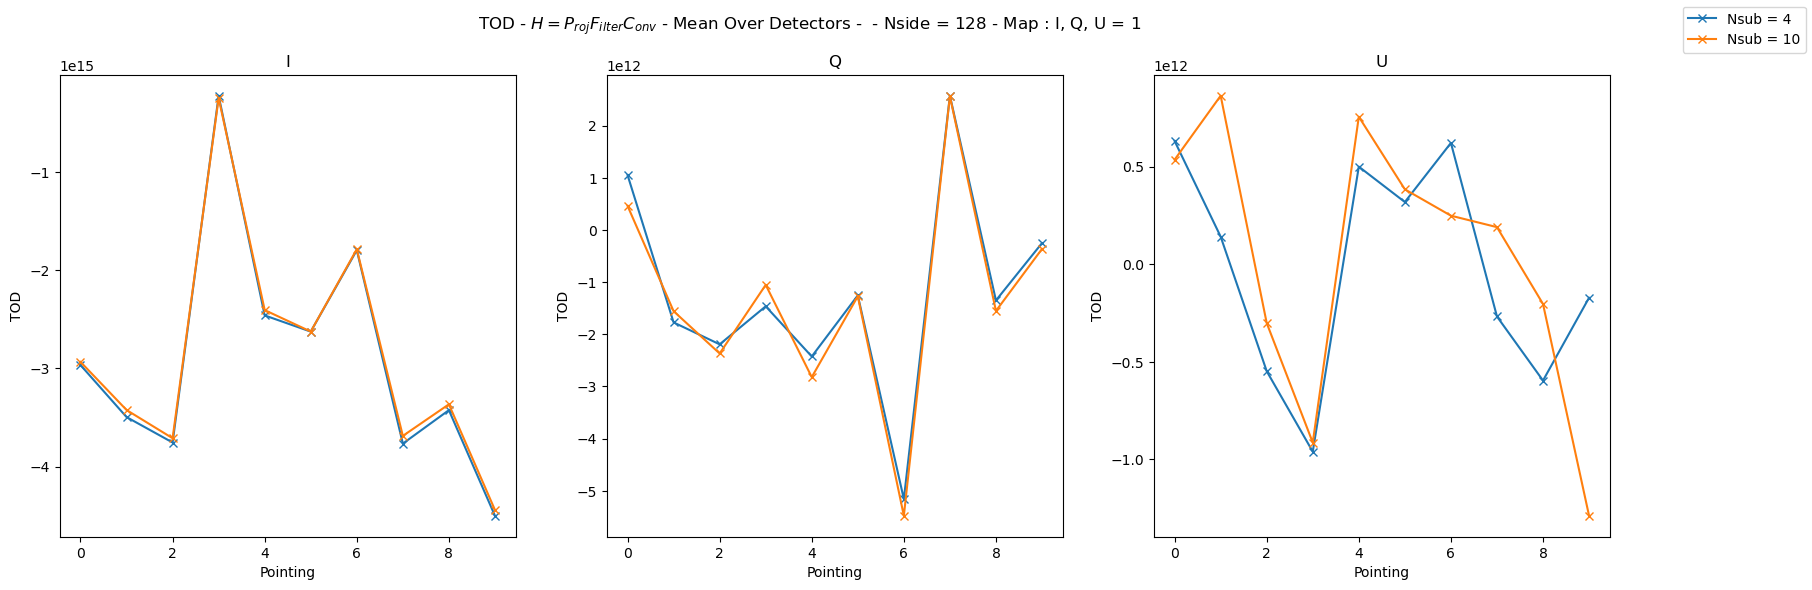

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

for i in range(len(TOD_list)):    
    ax1.plot(np.mean(TOD_list[i][..., 0], axis=0), '-x', label = f"Nsub = {nsub_list[i]}")
    ax2.plot(np.mean(TOD_list[i][..., 1], axis=0), '-x')
    ax3.plot(np.mean(TOD_list[i][..., 2], axis=0), '-x')

ax1.set_xlabel('Pointing')
ax1.set_ylabel("TOD")
ax1.set_title('I')

ax2.set_xlabel('Pointing')
ax2.set_ylabel("TOD")
ax2.set_title('Q')

ax3.set_xlabel('Pointing')
ax3.set_ylabel("TOD")
ax3.set_title('U')

fig.legend()
fig.suptitle(r'TOD - $H = P_{roj}F_{ilter}C_{onv}$ - Mean Over Detectors - ' + f' - Nside = {nside} - Map : {map_title}')

Text(0.5, 0.98, 'TOD - $H = P_{roj}F_{ilter}C_{onv}$ - Detector 0 - Nside = 128 - Map : I, Q, U = 1')

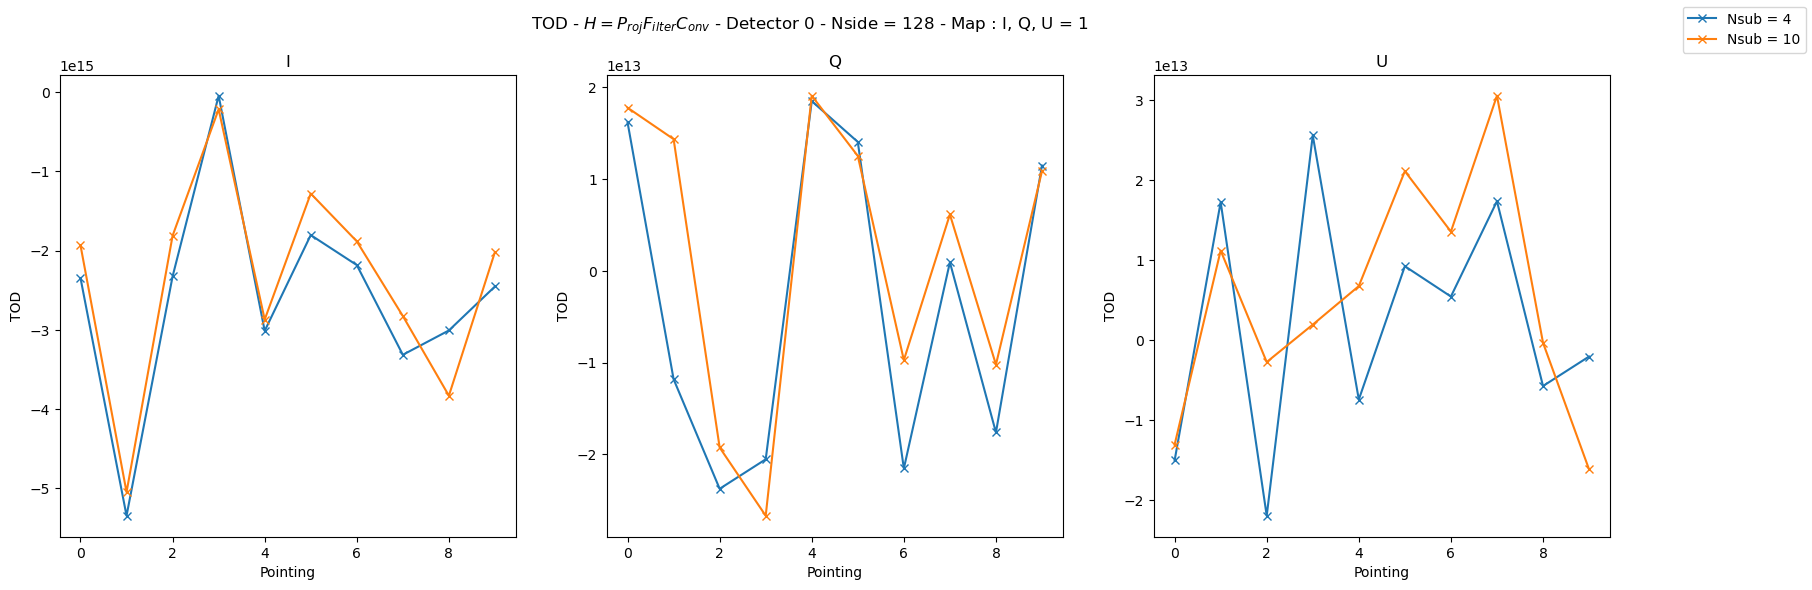

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

for i in range(len(TOD_list)):    
    ax1.plot(TOD_list[i][idet, :, 0], '-x', label = f"Nsub = {nsub_list[i]}")
    ax2.plot(TOD_list[i][idet, :, 1], '-x')
    ax3.plot(TOD_list[i][idet, :, 2], '-x')

ax1.set_xlabel('Pointing')
ax1.set_ylabel("TOD")
ax1.set_title('I')

ax2.set_xlabel('Pointing')
ax2.set_ylabel("TOD")
ax2.set_title('Q')

ax3.set_xlabel('Pointing')
ax3.set_ylabel("TOD")
ax3.set_title('U')

fig.legend()
fig.suptitle(r'TOD - $H = P_{roj}F_{ilter}C_{onv}$ - Detector' + f' {idet} - Nside = {nside} - Map : {map_title}')

Text(0.5, 0.98, 'Convergence of the TOD sub-operators - $H = P_{roj}F_{ilter}C_{onv}$ - Mean Over Detectors - Nside = 128 - Map : I, Q, U = 1')

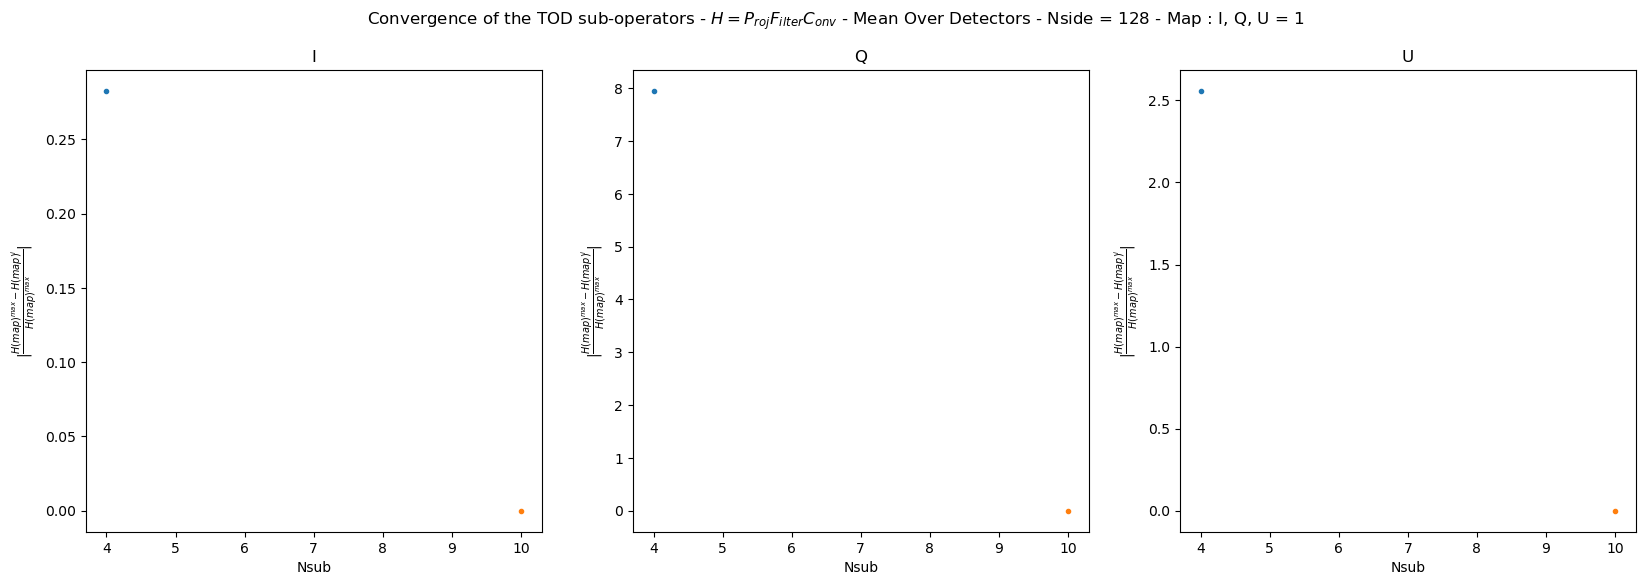

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

for i in range(len(TOD_list)):
    rel_diff = (TOD_list[i] - TOD_list[-1]) / TOD_list[-1]
    
    ax1.plot(nsub_list[i], np.mean(np.abs(rel_diff)[:, isample, 0]), '.')
    ax2.plot(nsub_list[i], np.mean(np.abs(rel_diff)[:, isample, 1]), '.')
    ax3.plot(nsub_list[i], np.mean(np.abs(rel_diff)[:, isample, 2]), '.')

ax1.set_xlabel('Nsub')
ax1.set_ylabel(r'|$\frac{H(map)^{max} - H(map)^{i}}{H(map)^{max}}$|')
ax1.set_title('I')

ax2.set_xlabel('Nsub')
ax2.set_ylabel(r'|$\frac{H(map)^{max} - H(map)^{i}}{H(map)^{max}}$|')
ax2.set_title('Q')

ax3.set_xlabel('Nsub')
ax3.set_ylabel(r'|$\frac{H(map)^{max} - H(map)^{i}}{H(map)^{max}}$|')
ax3.set_title('U')

fig.suptitle(r'Convergence of the TOD sub-operators - $H = P_{roj}F_{ilter}C_{onv}$ - Mean Over Detectors' + f' - Nside = {nside} - Map : {map_title}')

Text(0.5, 0.98, 'Convergence of the TOD sub-operators - $H = P_{roj}F_{ilter}C_{onv}$ - Detector 0 - Nside = 128 - Map : I, Q, U = 1')

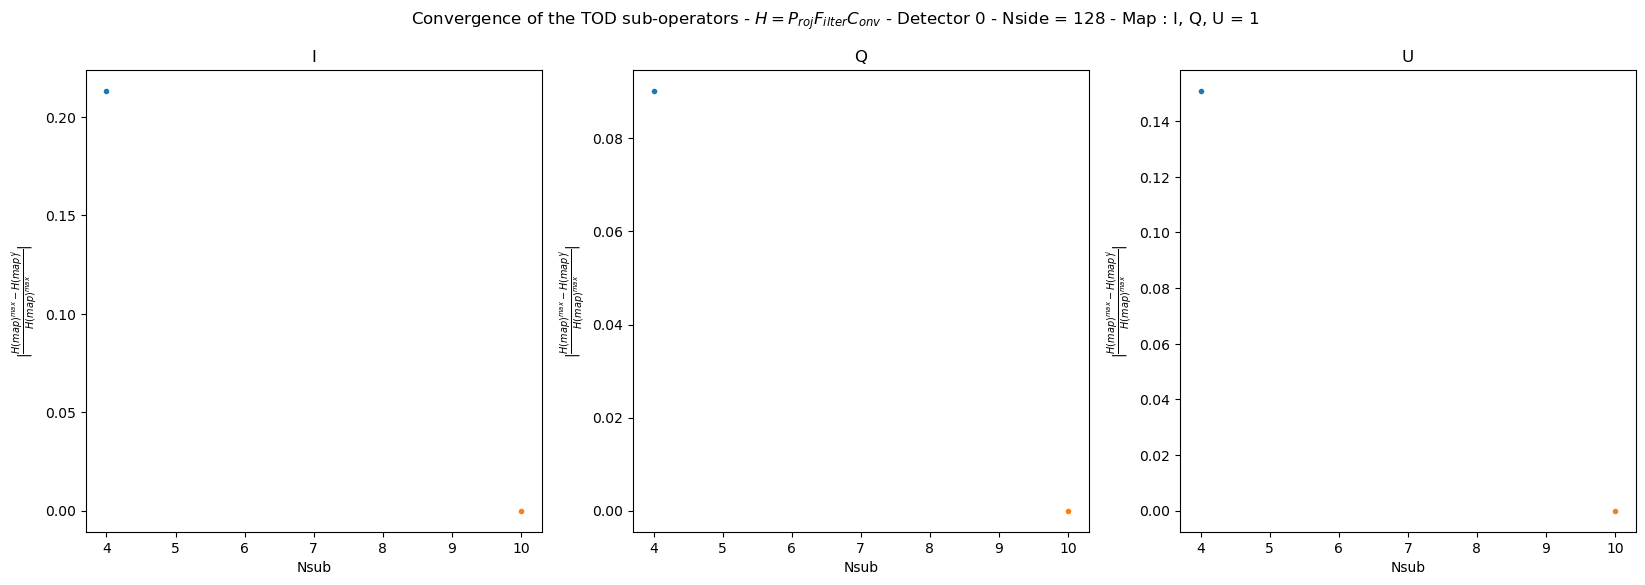

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

for i in range(len(TOD_list)):
    rel_diff = (TOD_list[i] - TOD_list[-1]) / TOD_list[-1]
    
    ax1.plot(nsub_list[i], np.mean(np.abs(rel_diff)[idet, isample, 0]), '.')
    ax2.plot(nsub_list[i], np.mean(np.abs(rel_diff)[idet, isample, 1]), '.')
    ax3.plot(nsub_list[i], np.mean(np.abs(rel_diff)[idet, isample, 2]), '.')

ax1.set_xlabel('Nsub')
ax1.set_ylabel(r'|$\frac{H(map)^{max} - H(map)^{i}}{H(map)^{max}}$|')
ax1.set_title('I')

ax2.set_xlabel('Nsub')
ax2.set_ylabel(r'|$\frac{H(map)^{max} - H(map)^{i}}{H(map)^{max}}$|')
ax2.set_title('Q')

ax3.set_xlabel('Nsub')
ax3.set_ylabel(r'|$\frac{H(map)^{max} - H(map)^{i}}{H(map)^{max}}$|')
ax3.set_title('U')

fig.suptitle(r'Convergence of the TOD sub-operators - $H = P_{roj}F_{ilter}C_{onv}$ - Detector' + f' {idet} - Nside = {nside} - Map : {map_title}')